In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-9vfev10f
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-9vfev10f
  Created wheel for albumentations: filename=albumentations-0.5.2-cp36-none-any.whl size=85254 sha256=ade54c4af314528e347f31b1635162bf4f591224885cf43310446a7f432ff00d
  Stored in directory: /tmp/pip-ephem-wheel-cache-6lekod2l/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [3]:
cd /content/drive/MyDrive/The School of AI/EVA Program/Assignment_10_Learning_Rate

/content/drive/MyDrive/The School of AI/EVA Program/Assignment_10_Learning_Rate


### Importing modules

In [4]:
from files.Albumentationtransform import AlbumentationTransforms
from files.train_test_transform import train_test_transform
from files.train_test_data_loader import train_test_data_loader
from files.input_data_explore import show_train_data
from files.resnet import ResNet18
from files.trainer import Training
from files.misclassified_images import misclassified_images
from files.gradcam import GradCAM
from files.utils import visualize_cam, denormalize
from files.lr_finder import LRFinder

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

#### Calculating mean and std for normalization

In [6]:
train_transforms, test_transforms = train_test_transform()

train_data_set = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform= train_transforms)
test_data_set = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform= test_transforms)

train_data = train_data_set.data
test_data = test_data_set.data

train_test_combine = np.concatenate((train_data, test_data),axis=0)
train_test_combine.reshape(-1,train_test_combine.shape[-1])
mean=train_test_combine.reshape(-1,train_test_combine.shape[-1]).mean(0)/255
std=train_test_combine.reshape(-1,train_test_combine.shape[-1]).std(0)/255

Files already downloaded and verified
Files already downloaded and verified


### Applying transformations to the data and getting train and test data loader

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_transforms, test_transforms = train_test_transform(normalize= True, mean= mean, std= std)
train_loader, test_loader = train_test_data_loader(train_transforms, test_transforms)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

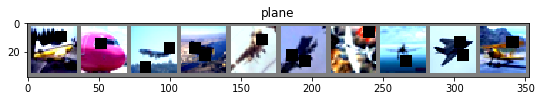

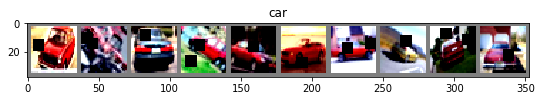

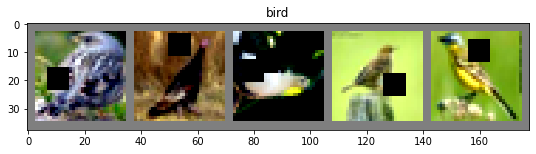

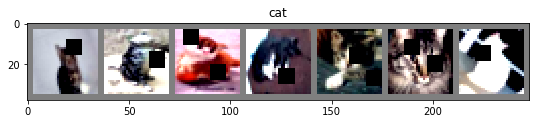

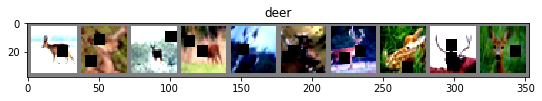

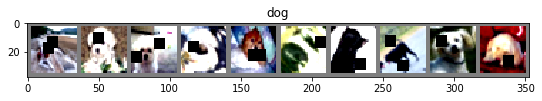

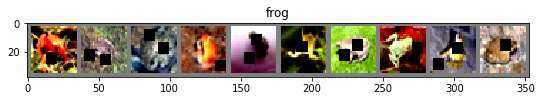

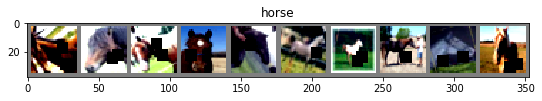

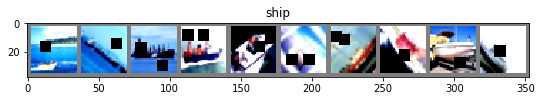

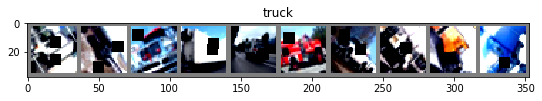

In [8]:
show_train_data(train_loader, classes)

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  ResNet18()
model.to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

### Finding Best LR

In [14]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.0000001, momentum=0.9)
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=10, num_iter=300 ,step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.85E-07


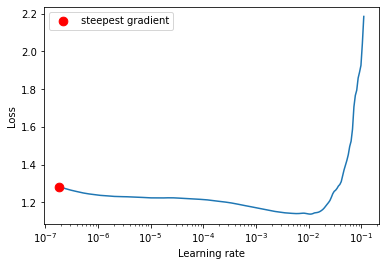

(<matplotlib.axes._subplots.AxesSubplot at 0x7fdffd9b1048>,
 1.8516484179121547e-07)

In [15]:
lr_finder.plot()

In [16]:
best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]

### Model training

In [18]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.SGD(model.parameters(), lr=best_lr, weight_decay=0.0019 , momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, patience = 3,min_lr=1e-4)
trainer = Training(model, optimizer, scheduler,train_loader, test_loader, device)
train_metric, test_metric = trainer.train(n_epoch=50)

Training the model for 50 epochs
EPOCH: 1




Test set: Average loss: 0.0048, Accuracy: 7968/10000 (79.68%)

Learning Rate =  0.010717668854455034
EPOCH: 2




Test set: Average loss: 0.0046, Accuracy: 7976/10000 (79.76%)

Learning Rate =  0.010717668854455034
EPOCH: 3




Test set: Average loss: 0.0056, Accuracy: 7722/10000 (77.22%)

Learning Rate =  0.010717668854455034
EPOCH: 4




Test set: Average loss: 0.0046, Accuracy: 8083/10000 (80.83%)

Learning Rate =  0.010717668854455034
EPOCH: 5




Test set: Average loss: 0.0040, Accuracy: 8230/10000 (82.30%)

Learning Rate =  0.010717668854455034
EPOCH: 6




Test set: Average loss: 0.0041, Accuracy: 8207/10000 (82.07%)

Learning Rate =  0.010717668854455034
EPOCH: 7




Test set: Average loss: 0.0040, Accuracy: 8322/10000 (83.22%)

Learning Rate =  0.0010717668854455034
EPOCH: 8




Test set: Average loss: 0.0028, Accuracy: 8831/10000 (88.31%)

Learning Rate =  0.0010717668854455034
EPOCH: 9




Test set: Average loss: 0.0027, Accuracy: 8862/10000 (88.62%)

Learning Rate =  0.0010717668854455034
EPOCH: 10




Test set: Average loss: 0.0026, Accuracy: 8905/10000 (89.05%)

Learning Rate =  0.0010717668854455034
EPOCH: 11




Test set: Average loss: 0.0026, Accuracy: 8900/10000 (89.00%)

Learning Rate =  0.00010717668854455035
EPOCH: 12




Test set: Average loss: 0.0026, Accuracy: 8932/10000 (89.32%)

Learning Rate =  0.00010717668854455035
EPOCH: 13




Test set: Average loss: 0.0025, Accuracy: 8934/10000 (89.34%)

Learning Rate =  0.00010717668854455035
EPOCH: 14




Test set: Average loss: 0.0025, Accuracy: 8935/10000 (89.35%)

Learning Rate =  0.00010717668854455035
EPOCH: 15




Test set: Average loss: 0.0025, Accuracy: 8942/10000 (89.42%)

Learning Rate =  0.0001
EPOCH: 16




Test set: Average loss: 0.0025, Accuracy: 8941/10000 (89.41%)

Learning Rate =  0.0001
EPOCH: 17




Test set: Average loss: 0.0025, Accuracy: 8951/10000 (89.51%)

Learning Rate =  0.0001
EPOCH: 18




Test set: Average loss: 0.0025, Accuracy: 8958/10000 (89.58%)

Learning Rate =  0.0001
EPOCH: 19




Test set: Average loss: 0.0025, Accuracy: 8937/10000 (89.37%)

Learning Rate =  0.0001
EPOCH: 20




Test set: Average loss: 0.0025, Accuracy: 8949/10000 (89.49%)

Learning Rate =  0.0001
EPOCH: 21




Test set: Average loss: 0.0024, Accuracy: 8961/10000 (89.61%)

Learning Rate =  0.0001
EPOCH: 22




Test set: Average loss: 0.0024, Accuracy: 8965/10000 (89.65%)

Learning Rate =  0.0001
EPOCH: 23




Test set: Average loss: 0.0024, Accuracy: 8964/10000 (89.64%)

Learning Rate =  0.0001
EPOCH: 24




Test set: Average loss: 0.0024, Accuracy: 8952/10000 (89.52%)

Learning Rate =  0.0001
EPOCH: 25




Test set: Average loss: 0.0024, Accuracy: 8960/10000 (89.60%)

Learning Rate =  0.0001
EPOCH: 26




Test set: Average loss: 0.0025, Accuracy: 8962/10000 (89.62%)

Learning Rate =  0.0001
EPOCH: 27




Test set: Average loss: 0.0025, Accuracy: 8956/10000 (89.56%)

Learning Rate =  0.0001
EPOCH: 28




Test set: Average loss: 0.0024, Accuracy: 8961/10000 (89.61%)

Learning Rate =  0.0001
EPOCH: 29




Test set: Average loss: 0.0024, Accuracy: 8952/10000 (89.52%)

Learning Rate =  0.0001
EPOCH: 30




Test set: Average loss: 0.0024, Accuracy: 8969/10000 (89.69%)

Learning Rate =  0.0001
EPOCH: 31




Test set: Average loss: 0.0024, Accuracy: 8967/10000 (89.67%)

Learning Rate =  0.0001
EPOCH: 32




Test set: Average loss: 0.0024, Accuracy: 8964/10000 (89.64%)

Learning Rate =  0.0001
EPOCH: 33




Test set: Average loss: 0.0024, Accuracy: 8968/10000 (89.68%)

Learning Rate =  0.0001
EPOCH: 34




Test set: Average loss: 0.0024, Accuracy: 8961/10000 (89.61%)

Learning Rate =  0.0001
EPOCH: 35




Test set: Average loss: 0.0024, Accuracy: 8982/10000 (89.82%)

Learning Rate =  0.0001
EPOCH: 36




Test set: Average loss: 0.0024, Accuracy: 8984/10000 (89.84%)

Learning Rate =  0.0001
EPOCH: 37




Test set: Average loss: 0.0024, Accuracy: 8973/10000 (89.73%)

Learning Rate =  0.0001
EPOCH: 38




Test set: Average loss: 0.0024, Accuracy: 8981/10000 (89.81%)

Learning Rate =  0.0001
EPOCH: 39




Test set: Average loss: 0.0024, Accuracy: 8967/10000 (89.67%)

Learning Rate =  0.0001
EPOCH: 40




Test set: Average loss: 0.0024, Accuracy: 8971/10000 (89.71%)

Learning Rate =  0.0001
EPOCH: 41




Test set: Average loss: 0.0024, Accuracy: 8978/10000 (89.78%)

Learning Rate =  0.0001
EPOCH: 42




Test set: Average loss: 0.0024, Accuracy: 8979/10000 (89.79%)

Learning Rate =  0.0001
EPOCH: 43




Test set: Average loss: 0.0024, Accuracy: 8980/10000 (89.80%)

Learning Rate =  0.0001
EPOCH: 44




Test set: Average loss: 0.0024, Accuracy: 8981/10000 (89.81%)

Learning Rate =  0.0001
EPOCH: 45




Test set: Average loss: 0.0024, Accuracy: 8987/10000 (89.87%)

Learning Rate =  0.0001
EPOCH: 46




Test set: Average loss: 0.0024, Accuracy: 8986/10000 (89.86%)

Learning Rate =  0.0001
EPOCH: 47




Test set: Average loss: 0.0024, Accuracy: 8984/10000 (89.84%)

Learning Rate =  0.0001
EPOCH: 48




Test set: Average loss: 0.0024, Accuracy: 8995/10000 (89.95%)

Learning Rate =  0.0001
EPOCH: 49




Test set: Average loss: 0.0024, Accuracy: 8984/10000 (89.84%)

Learning Rate =  0.0001
EPOCH: 50




Test set: Average loss: 0.0024, Accuracy: 8998/10000 (89.98%)

Learning Rate =  0.0001


### Misclassified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

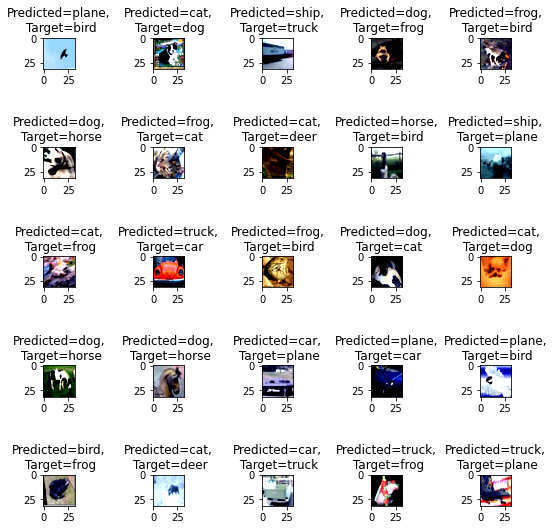

In [19]:
list_of_misclassified_images = misclassified_images(model, device, test_loader, classes)

### Train and test accuracy graphs

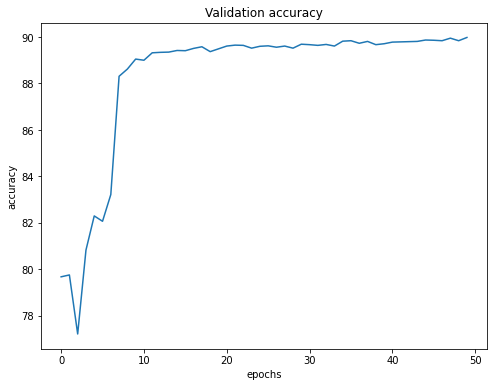

In [24]:
plt.figure(figsize=(8, 6))
plt.title('Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
test_acc, test_loss = test_metric
plt.plot(test_acc)
plt.show()

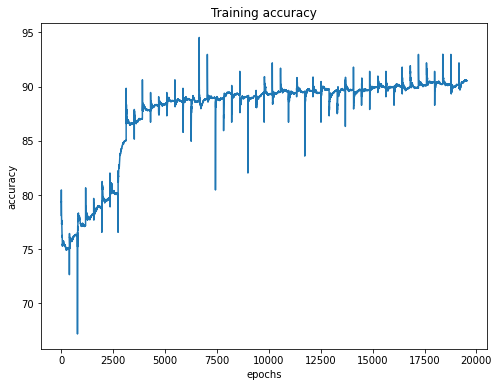

In [25]:
plt.figure(figsize=(8, 6))
plt.title('Training accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
train_acc, train_loss = train_metric
plt.plot(train_acc)
plt.show()

### Grad cam results

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

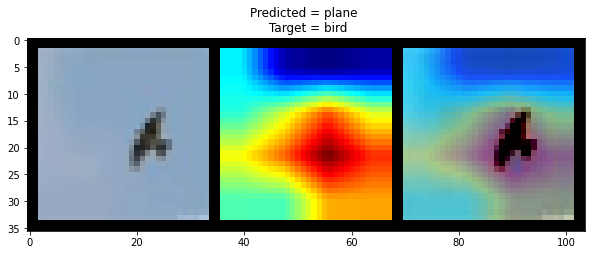

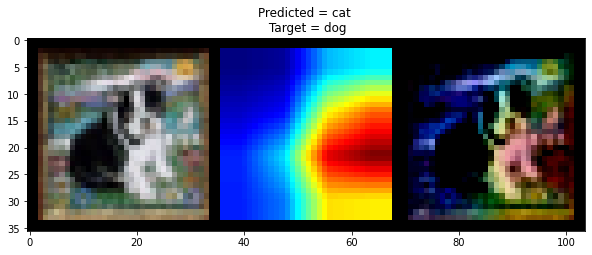

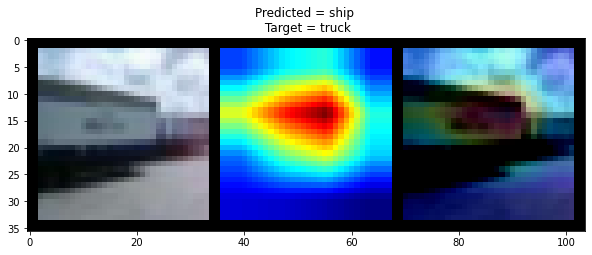

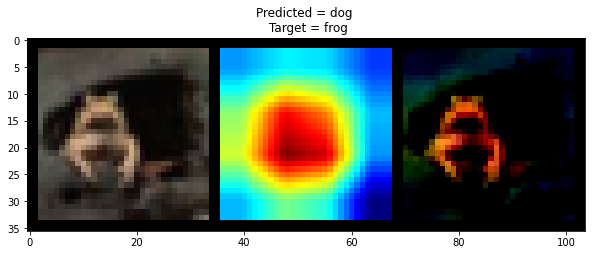

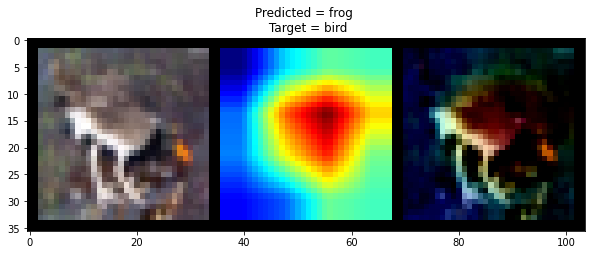

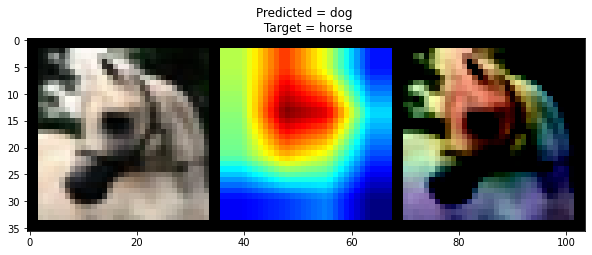

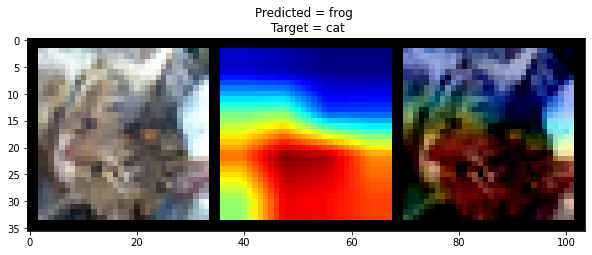

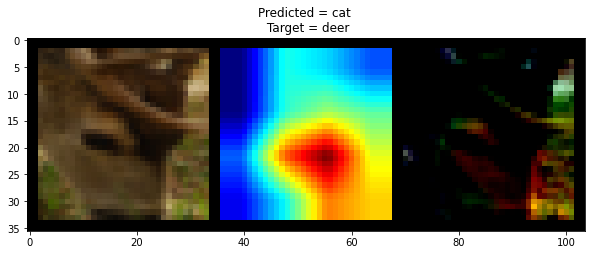

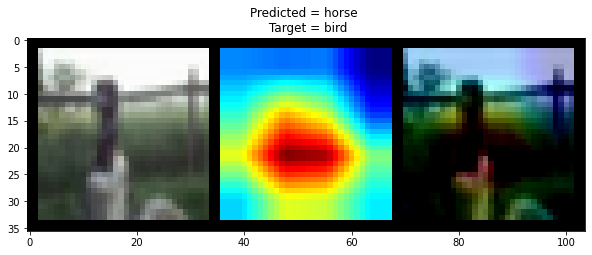

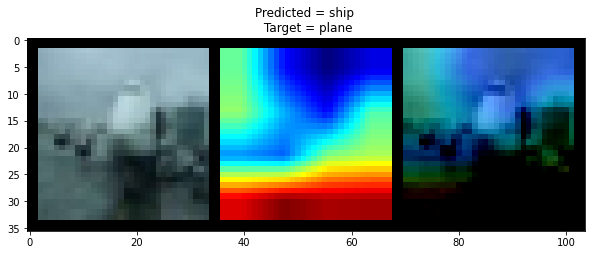

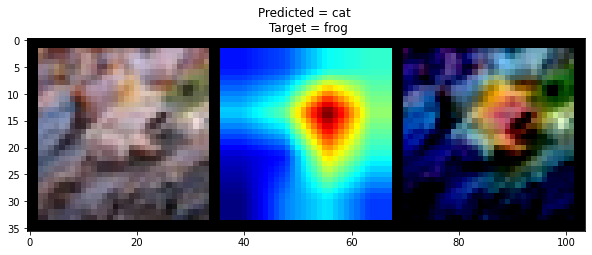

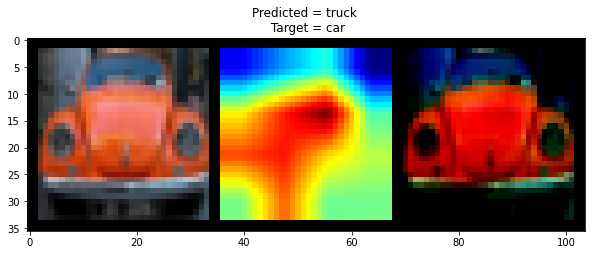

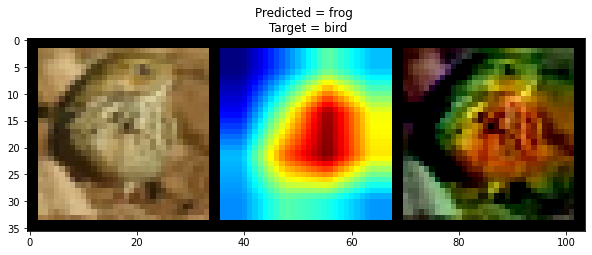

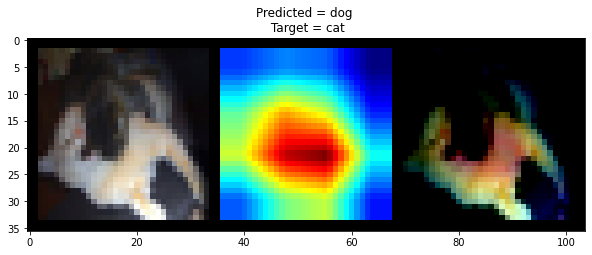

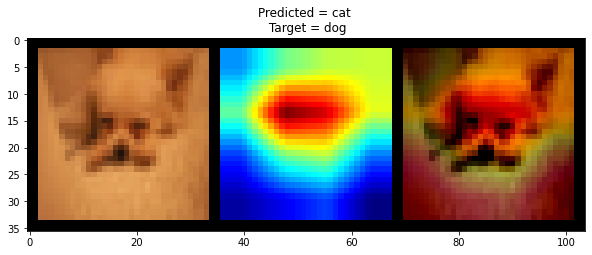

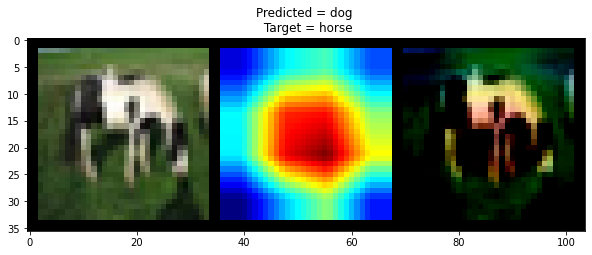

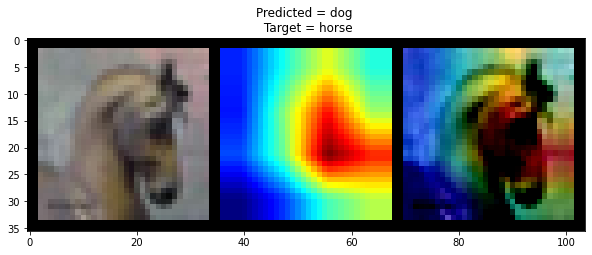

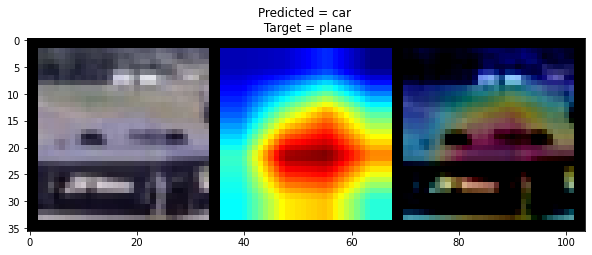

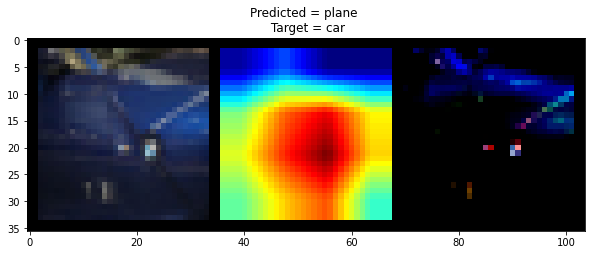

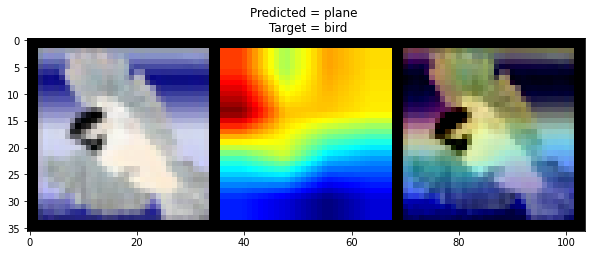

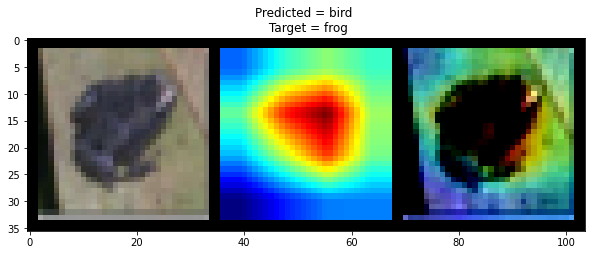

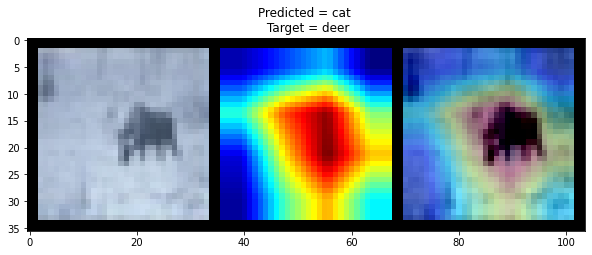

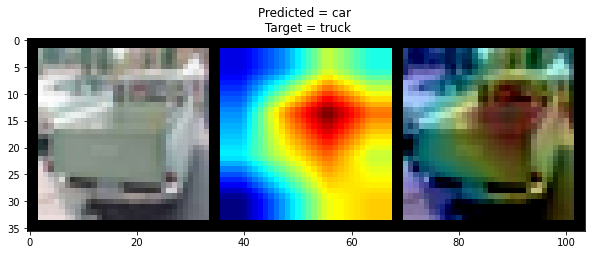

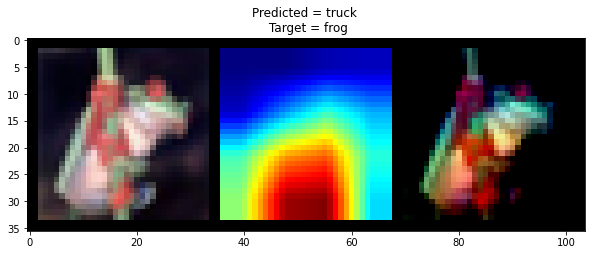

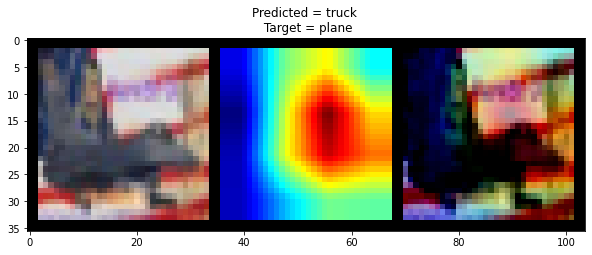

In [23]:
gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')


def imshow(image,predicted_label, target_label ):
    image = image.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(image, (1, 2, 0)),interpolation='none')
    plt.title(f'Predicted = {classes[int(predicted_label)]} \n Target = {classes[int(target_label)]}')

for misclassified_image in range(25):
  grad_cam_image_result = [denormalize(list_of_misclassified_images[misclassified_image][0].unsqueeze(0), mean, std).squeeze().cpu()]
  image = list_of_misclassified_images[misclassified_image][0].unsqueeze(0)
  predicted_label = list_of_misclassified_images[misclassified_image][1].cpu().numpy()
  target_label = list_of_misclassified_images[misclassified_image][2].cpu().numpy()
  mask, logit = gradcam(image)
  heatmap, cam_result = visualize_cam(mask, image)
  grad_cam_image_result.extend([heatmap])
  grad_cam_image_result.extend([cam_result])
  grid_image = make_grid(grad_cam_image_result,nrow=5)
  imshow(grid_image, predicted_label, target_label)


# Results

Best test accuracy : 89.69% ( 30th Epoch)